# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

## データの読み込み

In [2]:
sales_df_2 = pd.read_csv('5-4-1-sales-ts-2.csv')
sales_df_2['date'] = pd.to_datetime(sales_df_2['date'])
sales_df_2.head(n=3)

,date,sales,publicity
0,2010-01-01,95.8,0
1,2010-01-02,83.6,0
2,2010-01-03,94.1,0


## 図示

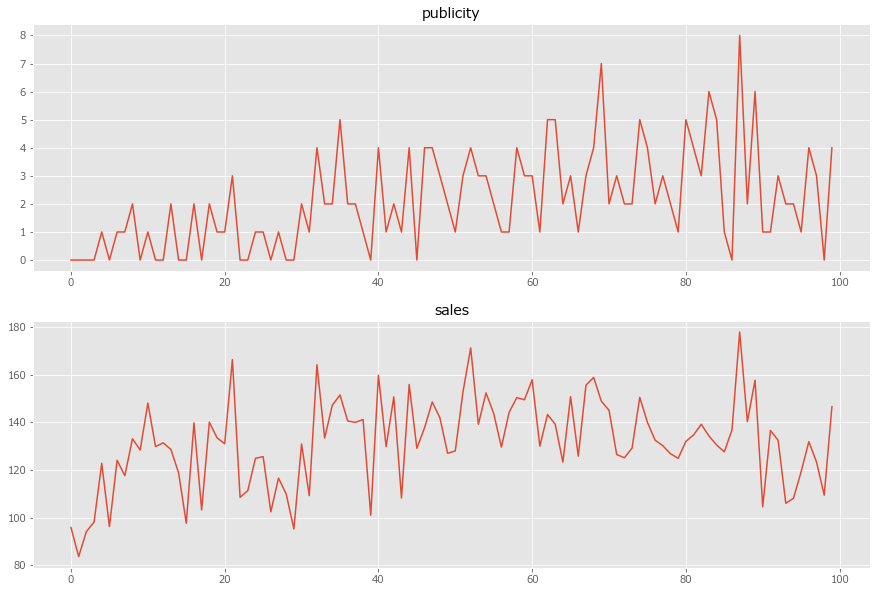

In [3]:
# サブプロットで2つの描画領域の作成
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

# publicityのグラフを作成
ax1.plot(sales_df_2['publicity'])
ax1.set_title('publicity')

# salesのグラフを作成
ax2.plot(sales_df_2['sales'])
ax2.set_title('sales')

# グラフを描画
plt.show()

# 普通の単回帰モデルの適用

## 補足：データの作成

In [4]:
data_list = dict(N=len(sales_df_2),
                 sales=sales_df_2['sales'],
                 d_publicity=sales_df_2['publicity'])

display(data_list)

{'N': 100,
 'sales': 0      95.8
 1      83.6
 2      94.1
 3      98.1
 4     122.8
       ...  
 95    119.3
 96    131.9
 97    123.3
 98    109.4
 99    146.6
 Name: sales, Length: 100, dtype: float64,
 'd_publicity': 0     0
 1     0
 2     0
 3     0
 4     1
      ..
 95    1
 96    4
 97    3
 98    0
 99    4
 Name: publicity, Length: 100, dtype: int64}

## 補足：推定の実行

In [5]:
# stanコードの記述
stan_code = '''
data {
  int N;                  
  vector[N] sales;       
  vector[N] d_publicity; 
}

parameters {
  real Intercept;        
  real publicity;             
  real<lower=0> sigma;    
}

model {
  for (i in 1:N) {
    sales[i] ~ normal(Intercept + publicity*d_publicity[i], sigma);
  }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
linear_reg_stan = stan_model.sampling(data=data_list, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5adbed5f32da08d3526402b7b2c39e09 NOW.


## 補足：固定効果の係数のみ出力

In [6]:
print(linear_reg_stan.stansummary(probs=[0.025, 0.5, 0.975],
                                  pars=['Intercept', 'publicity']))

Inference for Stan model: anon_model_5adbed5f32da08d3526402b7b2c39e09.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept 115.94    0.04   2.05 111.99 115.96 119.96   2214    1.0
publicity   7.38    0.02   0.74    5.9   7.37   8.81   2135    1.0

Samples were drawn using NUTS at Mon Sep  7 19:07:27 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 時点を分けた、2つの単回帰モデルの適用

## データの分割

In [7]:
sales_df_2_head = sales_df_2.head(n=50)
sales_df_2_tail = sales_df_2.tail(n=50)

## 前半のモデル化

In [8]:
# データの作成
data_list_head = dict(N=len(sales_df_2_head),
                      sales=sales_df_2_head['sales'],
                      d_publicity=sales_df_2_head['publicity'])

# stanコードの記述
stan_code = '''
data {
  int N;                  
  vector[N] sales;       
  vector[N] d_publicity; 
}

parameters {
  real Intercept;        
  real publicity;             
  real<lower=0> sigma;    
}

model {
  for (i in 1:N) {
    sales[i] ~ normal(Intercept + publicity*d_publicity[i], sigma);
  }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
mod_lm_head = stan_model.sampling(data=data_list_head,
                                           seed=1,
                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5adbed5f32da08d3526402b7b2c39e09 NOW.


## 後半のモデル化

In [9]:
# データの作成
data_list_tail = dict(N=len(sales_df_2_tail),
                      sales=sales_df_2_tail['sales'],
                      d_publicity=sales_df_2_tail['publicity'])

# stanコードの記述
stan_code = '''
data {
  int N;                  
  vector[N] sales;       
  vector[N] d_publicity; 
}

parameters {
  real Intercept;        
  real publicity;             
  real<lower=0> sigma;    
}

model {
  for (i in 1:N) {
    sales[i] ~ normal(Intercept + publicity*d_publicity[i], sigma);
  }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
mod_lm_tail = stan_model.sampling(data=data_list_tail,
                                           seed=1,
                                           n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5adbed5f32da08d3526402b7b2c39e09 NOW.


## 結果の表示
### 前半

In [10]:
print(mod_lm_head.stansummary(probs=[0.025, 0.5, 0.975],
                              pars=['Intercept', 'publicity']))

Inference for Stan model: anon_model_5adbed5f32da08d3526402b7b2c39e09.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept 110.73    0.05   2.49 105.78 110.74  115.7   2416    1.0
publicity  11.62    0.03   1.31   9.03   11.6  14.23   2394    1.0

Samples were drawn using NUTS at Mon Sep  7 19:08:09 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### 後半

In [11]:
print(mod_lm_tail.stansummary(probs=[0.025, 0.5, 0.975],
                              pars=['Intercept', 'publicity']))

Inference for Stan model: anon_model_5adbed5f32da08d3526402b7b2c39e09.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
Intercept 122.29    0.09   3.57 115.16  122.3 129.06   1621    1.0
publicity   5.07    0.03   1.04   3.05   5.07   7.25   1665    1.0

Samples were drawn using NUTS at Mon Sep  7 19:08:47 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 時変係数モデルの推定

## データの準備

In [12]:
data_list = dict(y=sales_df_2['sales'],
                 ex=sales_df_2['publicity'],
                 T=len(sales_df_2))

## モデルの推定

In [13]:
# stanコードの記述（）
stan_code = '''
data {
  int T;        // データ取得期間の長さ
  vector[T] ex; // 説明変数
  vector[T] y;  // 観測値
}

parameters {
  vector[T] mu;       // 水準成分の推定値
  vector[T] b;        // 時変係数の推定値
  real<lower=0> s_w;  // 水準成分の過程誤差の標準偏差
  real<lower=0> s_t;  // 時変係数の変動の大きさを表す標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

transformed parameters {
  vector[T] alpha;        // 各成分の和として得られる状態推定値
  
  for(i in 1:T) {
    alpha[i] = mu[i] + b[i] * ex[i];
  }

}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
    b[i] ~ normal(b[i-1], s_t);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(alpha[i], s_v);
  }

}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
time_varying_coef_stan = stan_model.sampling(data=data_list,
                                             seed=1, 
                                             iter=8000,
                                             warmup=2000,
                                             thin=6,
                                             n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b20732ce01b4a8a224224c9130169c3 NOW.


## 結果の表示

In [14]:
print(
    time_varying_coef_stan.stansummary(probs=[0.025, 0.5, 0.975],
                                       pars=['s_w', 's_t', 's_v', 'b[100]']))

Inference for Stan model: anon_model_8b20732ce01b4a8a224224c9130169c3.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w      3.74    0.05   1.25   1.54   3.65   6.59    611    1.0
s_t      1.01    0.02   0.36   0.47   0.96   1.88    562   1.01
s_v      9.58    0.03   1.08   7.62    9.5  11.86   1331    1.0
b[100]   6.33    0.04    2.2    2.1   6.27  10.76   3123    1.0

Samples were drawn using NUTS at Mon Sep  7 19:11:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：収束の確認など

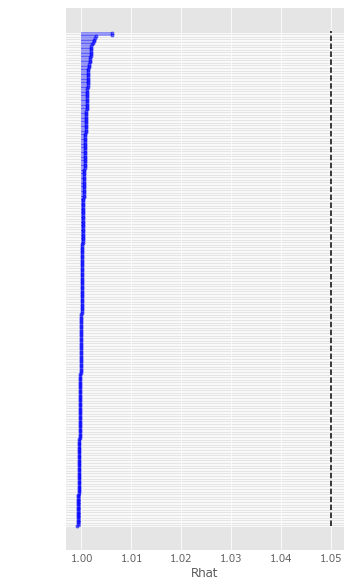

In [15]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary = pd.DataFrame(
    time_varying_coef_stan.summary()['summary'],
    columns=time_varying_coef_stan.summary()['summary_colnames'],
    index=time_varying_coef_stan.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary)

In [16]:
print('hmc_diagnostics of local_level:\n',
      pystan.diagnostics.check_hmc_diagnostics(time_varying_coef_stan))

hmc_diagnostics of local_level:
 {'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': True, 'energy': True}


## 参考：トレースなどのチェック

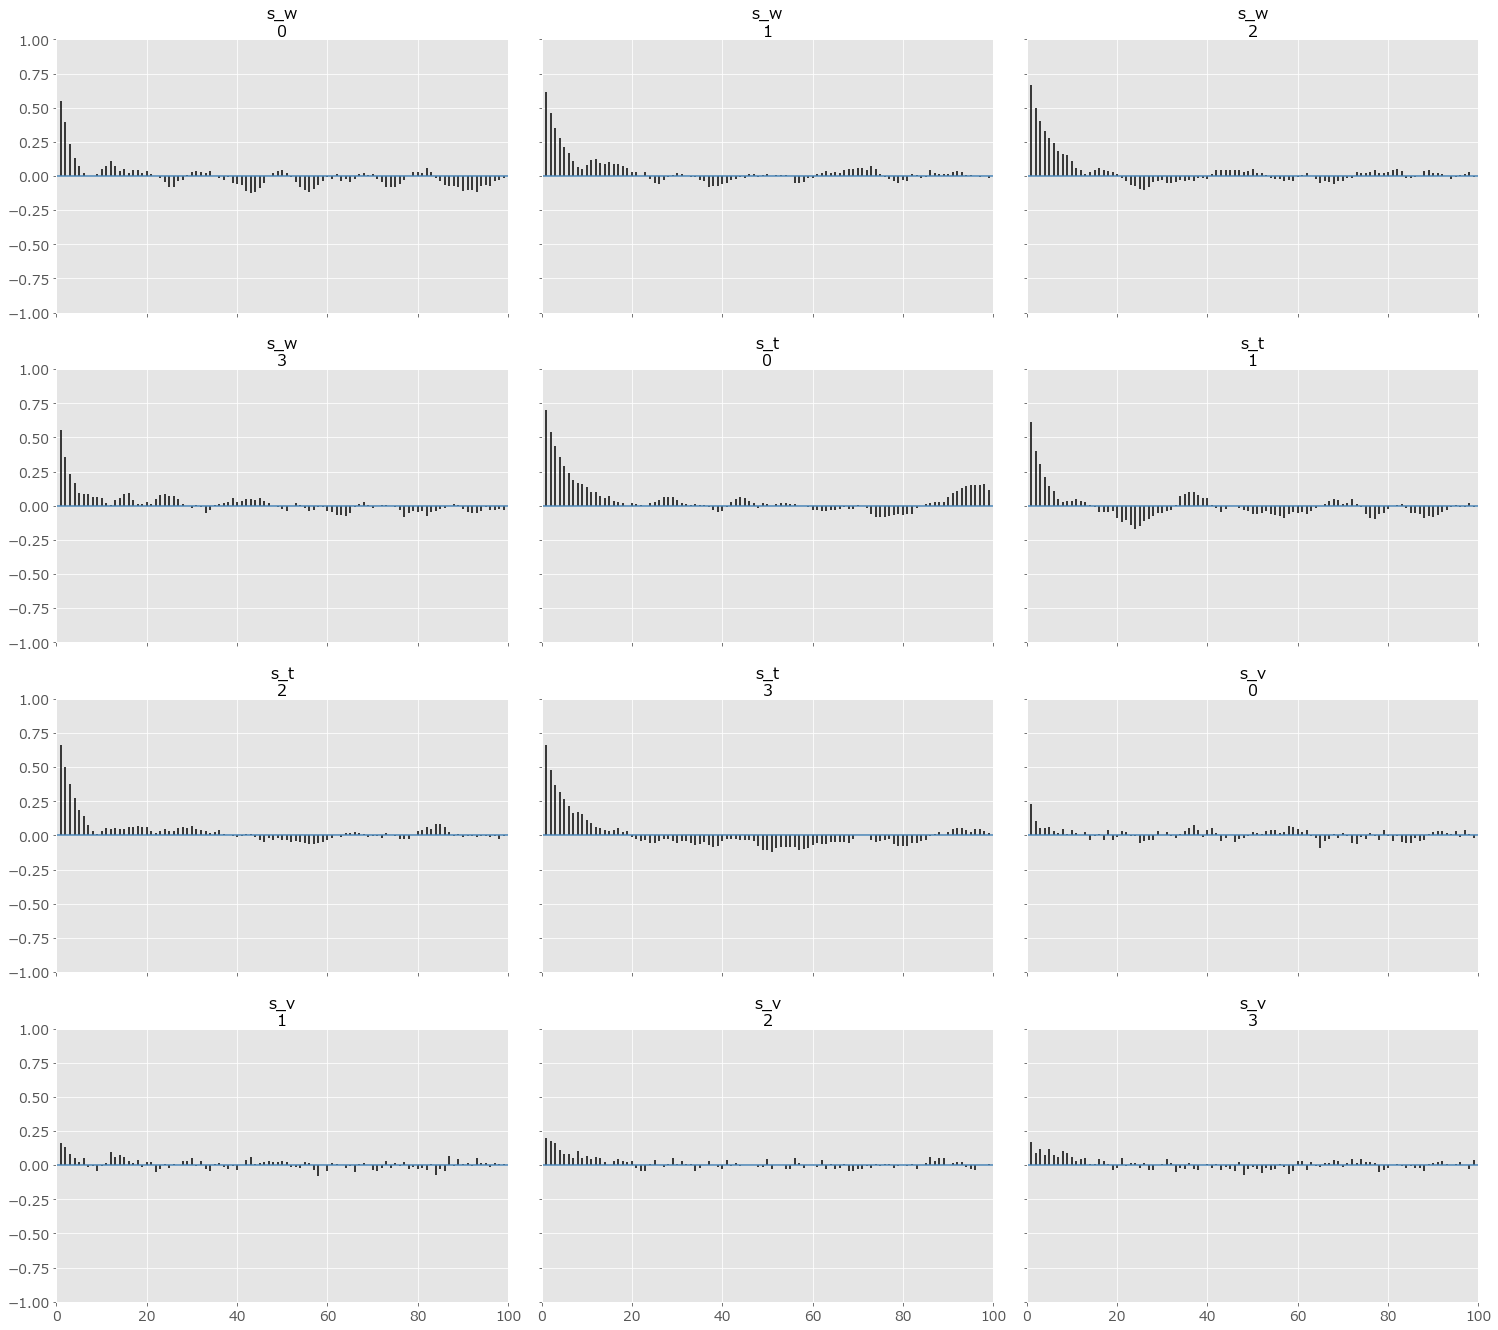

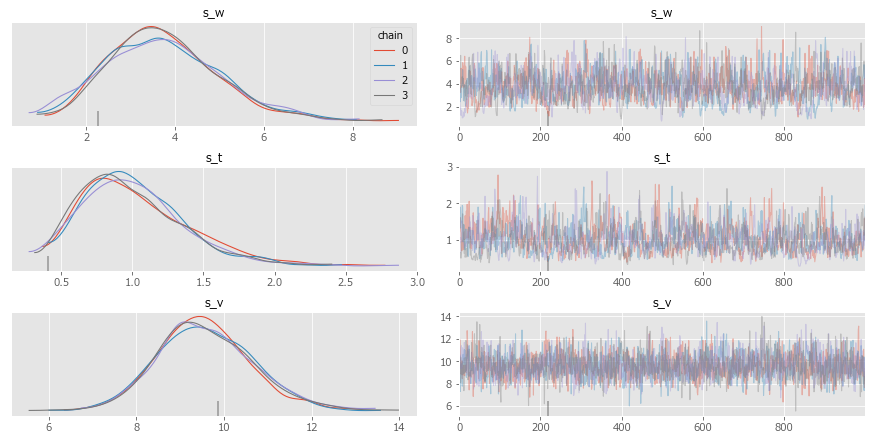

In [17]:
arviz.plot_autocorr(time_varying_coef_stan, var_names=["s_w", "s_t", "s_v"]);
arviz.plot_trace(time_varying_coef_stan, var_names=["s_w", "s_t", "s_v"],legend=True);

## すべての推定値を出力

In [18]:
print(time_varying_coef_stan.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_8b20732ce01b4a8a224224c9130169c3.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu[1]        96.6    0.13   5.85  85.12  96.63 108.42   1936    1.0
mu[2]       96.41    0.14   5.56  85.41   96.4 107.55   1656    1.0
mu[3]       98.18    0.12   5.07  88.23  98.08 108.19   1807    1.0
mu[4]      100.57     0.1   4.72  91.46  100.6 109.72   2459    1.0
mu[5]      103.31    0.08   4.57  94.29 103.29 112.31   3576    1.0
mu[6]      104.62    0.07   4.54  95.51 104.65 113.32   3695    1.0
mu[7]      107.45    0.07   4.69  98.26 107.45 116.64   3941    1.0
mu[8]      109.64    0.08   4.73 100.61 109.58 119.12   3708    1.0
mu[9]      112.81    0.09   4.94  103.4 112.61 123.05   3080    1.0
mu[10]     117.01    0.13   5.33 107.09 116.67 127.62   1634    1.0
mu[11]     119.44    0.16   5.86 108.92 119.16 131.45   1288   

# 推定された状態の図示

## MCMCサンプルの取得

In [19]:
mcmc_sample = time_varying_coef_stan.extract()

# 図示

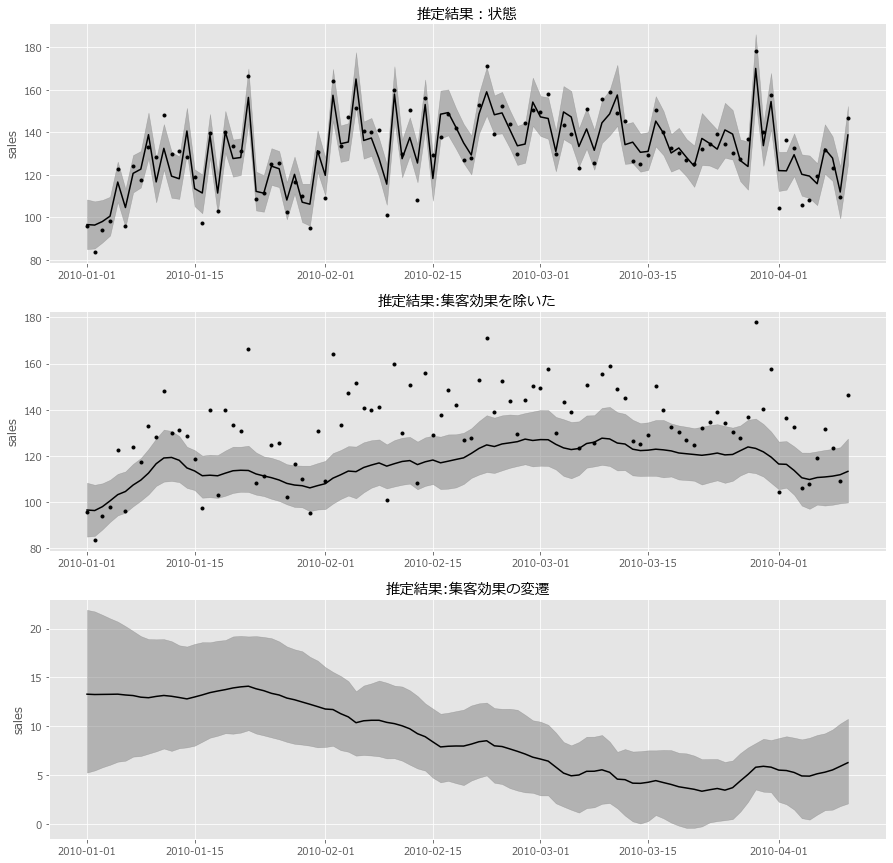

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

p_all = plotSSM(mcmc_sample=mcmc_sample,
                time_vec=sales_df_2['date'],
                obs_vec=sales_df_2['sales'],
                state_name='alpha',
                graph_title='推定結果：状態',
                y_label='sales',
                axes=ax[0])

p_mu = plotSSM(mcmc_sample=mcmc_sample,
                time_vec=sales_df_2['date'],
                obs_vec=sales_df_2['sales'],
                state_name='mu',
                graph_title='推定結果:集客効果を除いた',
                y_label='sales',
                axes=ax[1])

p_b = plotSSM(mcmc_sample=mcmc_sample,
                time_vec=sales_df_2['date'],
                state_name='b',
                graph_title='推定結果:集客効果の変遷',
                y_label='sales',
                axes=ax[2])
plt.show()

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["font.family"] = "Meiryo"

def plotSSM(mcmc_sample, time_vec, state_name, 
            graph_title, y_label, axes, obs_vec=None):

    # 状態空間モデルを図示する関数
    #
    # Args:
    #   mcmc_sample : MCMCサンプル
    #   time_vec    : 時間軸(datetime)のベクトル
    #   obs_vec     : (必要なら)観測値のベクトル
    #   state_name  : 図示する状態の変数名
    #   graph_title : グラフタイトル
    #   y_label     : y軸のラベル
    #   axes        : サブプロットの描画領域
    #
    # Returns:
    #   生成されたグラフ
    
    # すべての時点の状態の、95%区間と中央値
    result_df = pd.DataFrame(np.zeros([mcmc_sample[state_name].shape[1], 3]))
    for i in range(mcmc_sample[state_name].shape[1]):
        result_df.iloc[i,:] = np.percentile(mcmc_sample[state_name][:,i], q=[2.5, 50, 97.5])
        
    # 列名の変更
    result_df.columns = ["lwr", "fit", "upr"]
    
    # 時間軸の追加
    result_df['time'] = time_vec
    
    # 観測値の追加
    if obs_vec is not None:
        if obs_vec.isnull().all(axis=0) == False:
            result_df['obs'] = obs_vec
        
    # 図示
    
    axes.plot(result_df['time'], 
             result_df['fit'], 
             color='black')
    axes.fill_between(x=result_df['time'],
                     y1=result_df['upr'],
                     y2=result_df['lwr'],
                     color='gray',
                     alpha=0.5)
    axes.set_ylabel(y_label)
    axes.set_title(graph_title)
    
    # 観測値をグラフに追加
    if obs_vec is not None:
        if obs_vec.isnull().all(axis=0) == False:
            axes.plot(result_df['time'],
                     result_df['obs'],
                     marker='.',
                     linewidth=0,
                     color='black')
        
    # グラフを返す
    return axes